In [ ]:
# ==============================================================================
# 第一步：环境设置
# ==============================================================================
import pandas as pd
import numpy as np
from pathlib import Path

# ==============================================================================
# 第二步：文件路径配置
# ==============================================================================
# 使用您指定的输入文件路径
input_file = Path('../../2022C/附件/附件.xlsx')

# 使用您指定的输出目录路径
output_dir = Path('../../Data')
# 确保输出目录存在，如果不存在则创建
output_dir.mkdir(parents=True, exist_ok=True)

# ==============================================================================
# 第三步：数据加载与预处理 (包含高级缺失值填充)
# ==============================================================================
# --- (3.1) 加载数据 ---
df_info = pd.read_excel(input_file, sheet_name='表单1')
df_classified = pd.read_excel(input_file, sheet_name='表单2')
df_unclassified = pd.read_excel(input_file, sheet_name='表单3')

# --- (3.2) 核心预处理 ---
# 创建合并键
df_classified['文物编号'] = df_classified['文物采样点'].str.extract(r'(\d+)').astype(int)
# 合并数据
df_merged = pd.merge(df_classified, df_info, on='文物编号', how='left')

# 确定化学成分列
chemical_columns = [col for col in df_classified.columns if col not in ['文物采样点', '文物编号']]
# 处理化学成分缺失值
df_merged[chemical_columns] = df_merged[chemical_columns].fillna(0)
df_unclassified[chemical_columns] = df_unclassified[chemical_columns].fillna(0)

# --- (3.3) 【核心修改】高级颜色缺失值填充 ---
# 定义用于分组匹配的特征列
grouping_keys = ['类型', '表面风化', '纹饰']
# 使用groupby().transform()进行高效的众数填充
# transform会返回一个与原df_merged同样索引的Series，可以直接赋值
# lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "未知") 是核心逻辑：
# 1. x.mode() 找到组内的众数
# 2. x.mode()[0] 取第一个众数（以防有并列）
# 3. if not x.mode().empty 检查该组是否存在众数（即组内是否全是NaN）
# 4. 如果没有众数，则使用'未知'作为最终的备用填充值
df_merged['颜色'] = df_merged.groupby(grouping_keys)['颜色'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "未知")
)

# 对其他可能存在的分类变量缺失值进行通用填充，以确保数据完整性
for col in ['纹饰', '类型', '表面风化']:
     if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna('未知')

# --- (3.4) 按规则筛选有效数据 ---
df_merged['成分总和'] = df_merged[chemical_columns].sum(axis=1)
df_cleaned = df_merged[(df_merged['成分总和'] >= 85) & (df_merged['成分总和'] <= 105)].copy()

df_unclassified['成分总和'] = df_unclassified[chemical_columns].sum(axis=1)
df_unclassified_cleaned = df_unclassified[(df_unclassified['成分总和'] >= 85) & (df_unclassified['成分总和'] <= 105)].copy()

print(f"数据预处理完成: 得到 {len(df_cleaned)} 条有效已分类样本 和 {len(df_unclassified_cleaned)} 条有效未分类样本。")


# ==============================================================================
# 第四步：数据量化 (按您的要求)
# ==============================================================================
# --- (4.1) 因变量 y 的量化 (目标编码) ---
type_mapping = {'铅钡': 0, '高钾': 1}
y_quantified = df_cleaned['类型'].map(type_mapping)

# --- (4.2) 自变量 X 的量化 (独热编码) ---
# 选取所有数值特征 (化学成分)
X_numeric = df_cleaned[chemical_columns]

# 【核心修改】选取原始的分类特征列进行独热编码，不再使用“_合并后”的版本
categorical_features_for_X = ['表面风化', '纹饰', '颜色']
X_categorical = df_cleaned[categorical_features_for_X]

# 执行独热编码
X_one_hot = pd.get_dummies(X_categorical, drop_first=True)

# 将数值特征和独热编码后的特征合并，构成最终的自变量矩阵 X
X_quantified = pd.concat([X_numeric, X_one_hot], axis=1)

print(f"数据量化完成: 最终特征矩阵 X 包含 {X_quantified.shape[1]} 个特征。")


# ==============================================================================
# 第五步：保存所有输出文件
# ==============================================================================
# --- (5.1) 保存清洗后的数据 ---
output_cleaned_file = output_dir / '处理后的数据.xlsx'
with pd.ExcelWriter(output_cleaned_file) as writer:
    df_cleaned.to_excel(writer, sheet_name='已分类清洗后数据', index=False)
    df_unclassified_cleaned.to_excel(writer, sheet_name='未分类清洗后数据', index=False)
print(f"1. 清洗后的数据已保存至 -> 【{output_cleaned_file}】")

# --- (5.2) 保存量化后的建模专用数据 ---
output_X_file = output_dir / 'X_quantified.csv'
output_y_file = output_dir / 'y_quantified.csv'

X_quantified.to_csv(output_X_file, index=False)
y_quantified.to_csv(output_y_file, index=False, header=['类型'])
print(f"2. 量化后的特征矩阵X已保存至 -> 【{output_X_file}】")
print(f"3. 量化后的目标变量y已保存至 -> 【{output_y_file}】")

数据预处理完成: 得到 67 条有效已分类样本 和 8 条有效未分类样本。
数据量化完成: 最终特征矩阵 X 包含 24 个特征。
1. 清洗后的数据已保存至 -> 【..\..\Data\清洗后的数据.xlsx】
2. 量化后的特征矩阵X已保存至 -> 【..\..\Data\X_quantified.csv】
3. 量化后的目标变量y已保存至 -> 【..\..\Data\y_quantified.csv】


-> “数据量化流程总结”图表已保存至: 数据量化流程总结.png


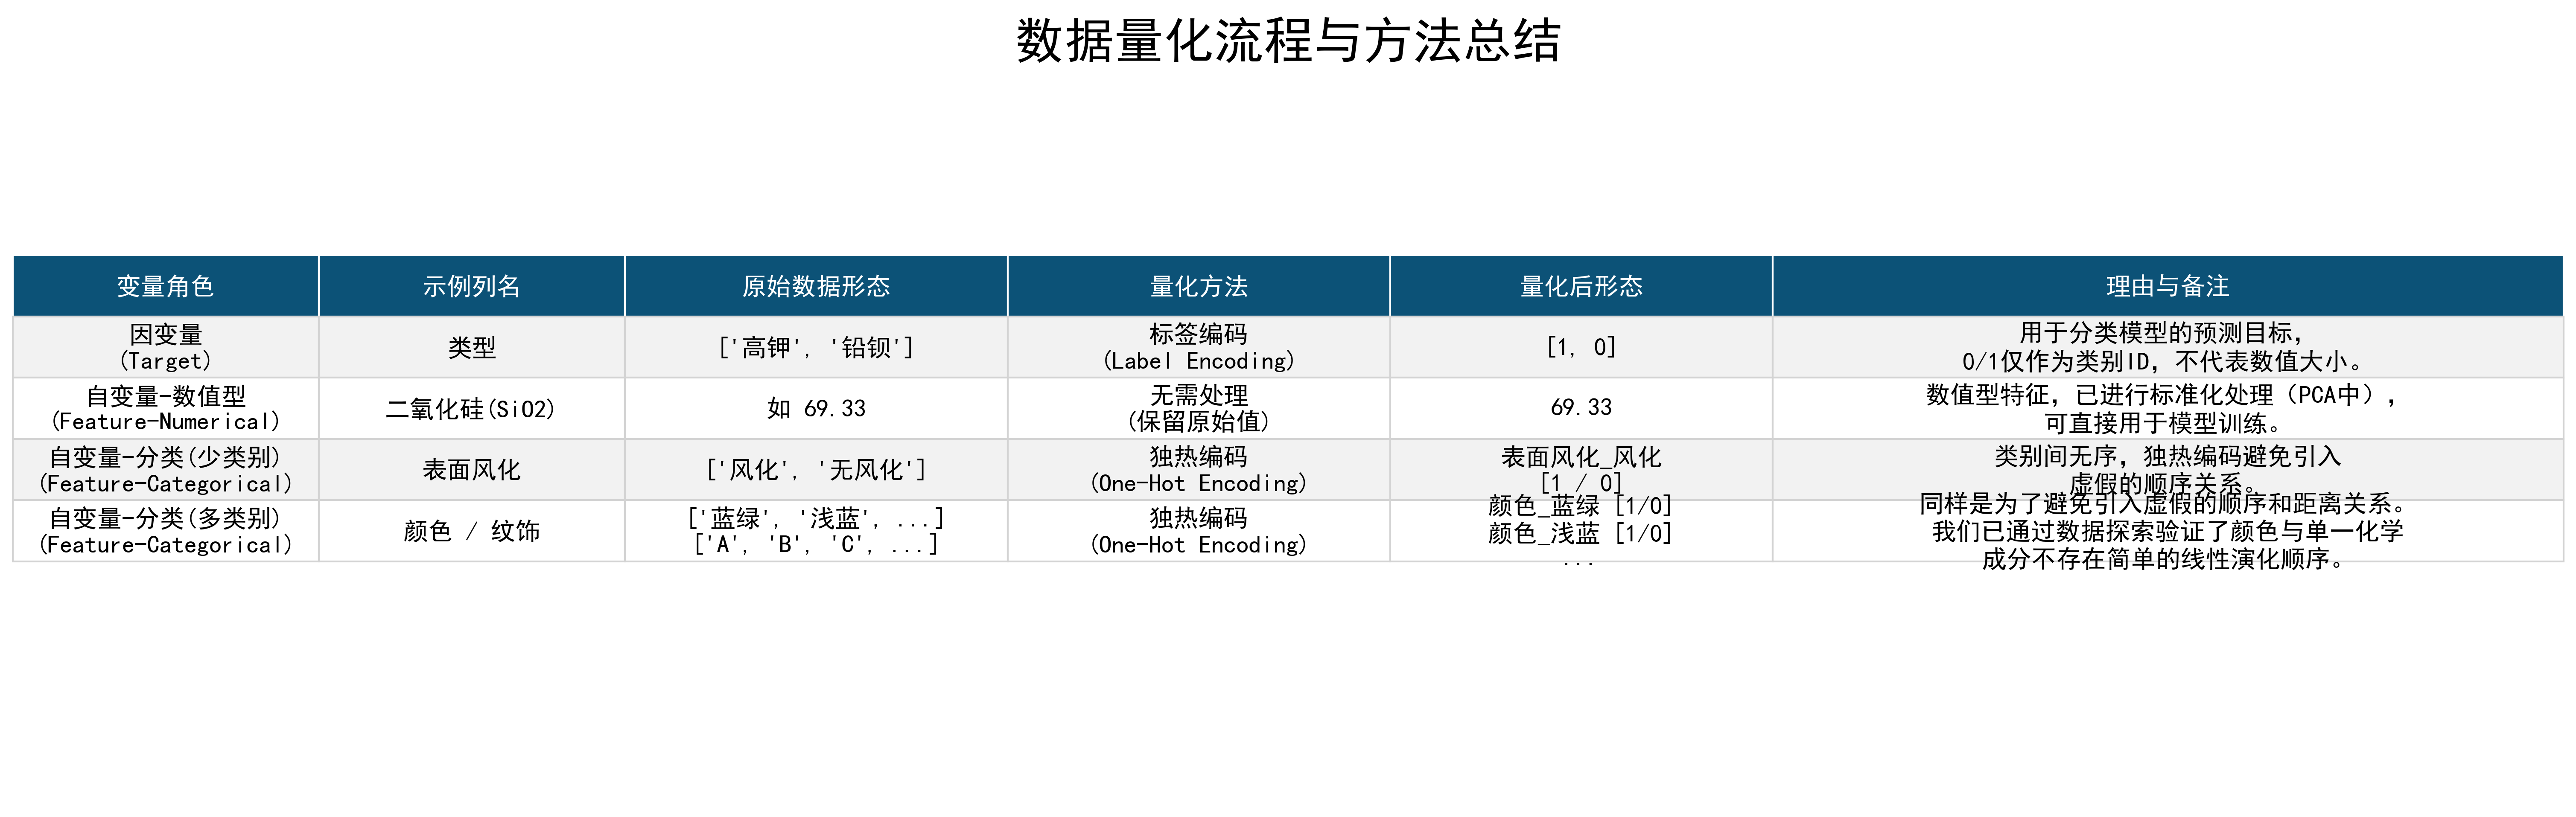

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 绘图配置 ---
# 记下了您的要求，确保中文字体、字号和风格符合标准
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# --- 表格内容定义 ---
table_data = [
    ["因变量\n(Target)", "类型", "['高钾', '铅钡']", "标签编码\n(Label Encoding)", "[1, 0]", "用于分类模型的预测目标，\n0/1仅作为类别ID，不代表数值大小。"],
    ["自变量-数值型\n(Feature-Numerical)", "二氧化硅(SiO2)", "如 69.33", "无需处理\n(保留原始值)", "69.33", "数值型特征，已进行标准化处理（PCA中），\n可直接用于模型训练。"],
    ["自变量-分类(少类别)\n(Feature-Categorical)", "表面风化", "['风化', '无风化']", "独热编码\n(One-Hot Encoding)", "表面风化_风化\n[1 / 0]", "类别间无序，独热编码避免引入\n虚假的顺序关系。"],
    ["自变量-分类(多类别)\n(Feature-Categorical)", "颜色 / 纹饰", "['蓝绿', '浅蓝', ...]\n['A', 'B', 'C', ...]", "独热编码\n(One-Hot Encoding)", "颜色_蓝绿 [1/0]\n颜色_浅蓝 [1/0]\n...", "同样是为了避免引入虚假的顺序和距离关系。\n我们已通过数据探索验证了颜色与单一化学\n成分不存在简单的线性演化顺序。"]
]

columns = ['变量角色', '示例列名', '原始数据形态', '量化方法', '量化后形态', '理由与备注']
df_table = pd.DataFrame(table_data, columns=columns)

# --- 核心绘图步骤 ---
fig, ax = plt.subplots(figsize=(20, 7)) # 调整画布大小以适应表格
ax.axis('off') # 隐藏坐标轴

# 创建表格
table = ax.table(
    cellText=df_table.values,
    colLabels=df_table.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.12, 0.12, 0.15, 0.15, 0.15, 0.31] # 调整列宽
)

# --- 美化表格 ---
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 2.5) # 调整表格单元格的整体大小

# 设置表头样式
for (i, j), cell in table.get_celld().items():
    if i == 0: # 这是表头行
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#0c5277') # 使用深色背景
        cell.set_edgecolor('white')
    else: # 数据行
        cell.set_facecolor('white')
        cell.set_edgecolor('lightgrey')
        # 交替行颜色
        if i % 2 != 0:
            cell.set_facecolor('#f2f2f2')

# 设置文本对齐
for i in range(len(columns)):
    for j in range(len(table_data) + 1):
        table[j, i].set_text_props(ha='center', va='center', wrap=True)

fig.suptitle('数据量化流程与方法总结', fontsize=28, weight='bold', y=0.9)

plt.tight_layout()

# 保存图表
save_file = "数据量化流程总结.png"
plt.savefig(save_file, bbox_inches='tight', pad_inches=0.1)
print(f"-> “数据量化流程总结”图表已保存至: {save_file}")
plt.show()

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 绘图配置 ---
# 记下了您的要求，设置大字号、学术风格、并确保中文正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150 # 提高notebook显示的清晰度
# 我记下了您的偏好，继续使用viridis配色方案
custom_palette = "viridis" 

# --- 加载数据 ---
# 从我们上一步保存的文件中读取干净的数据
try:
    df_cleaned = pd.read_excel('../../Data/处理后的数据.xlsx', sheet_name='已分类清洗后数据')
    df_unclassified_cleaned = pd.read_excel('../../Data/处理后的数据.xlsx', sheet_name='未分类清洗后数据')
    print("成功加载清洗后的数据，可视化分析准备就绪。")
except FileNotFoundError:
    print("错误：未找到'处理后的数据.xlsx'文件，请先运行上一阶段的完整代码。")

# 筛选出化学成分列，备用
chemical_columns = [col for col in df_cleaned.columns if '(' in col and ')' in col]

成功加载清洗后的数据，可视化分析准备就绪。


C:\Users\86185\AppData\Local\Temp\ipykernel_16856\3906172328.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette=custom_palette)
C:\Users\86185\AppData\Local\Temp\ipykernel_16856\3906172328.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette=custom_palette)
C:\Users\86185\AppData\Local\Temp\ipykernel_16856\3906172328.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette=custom_palette)


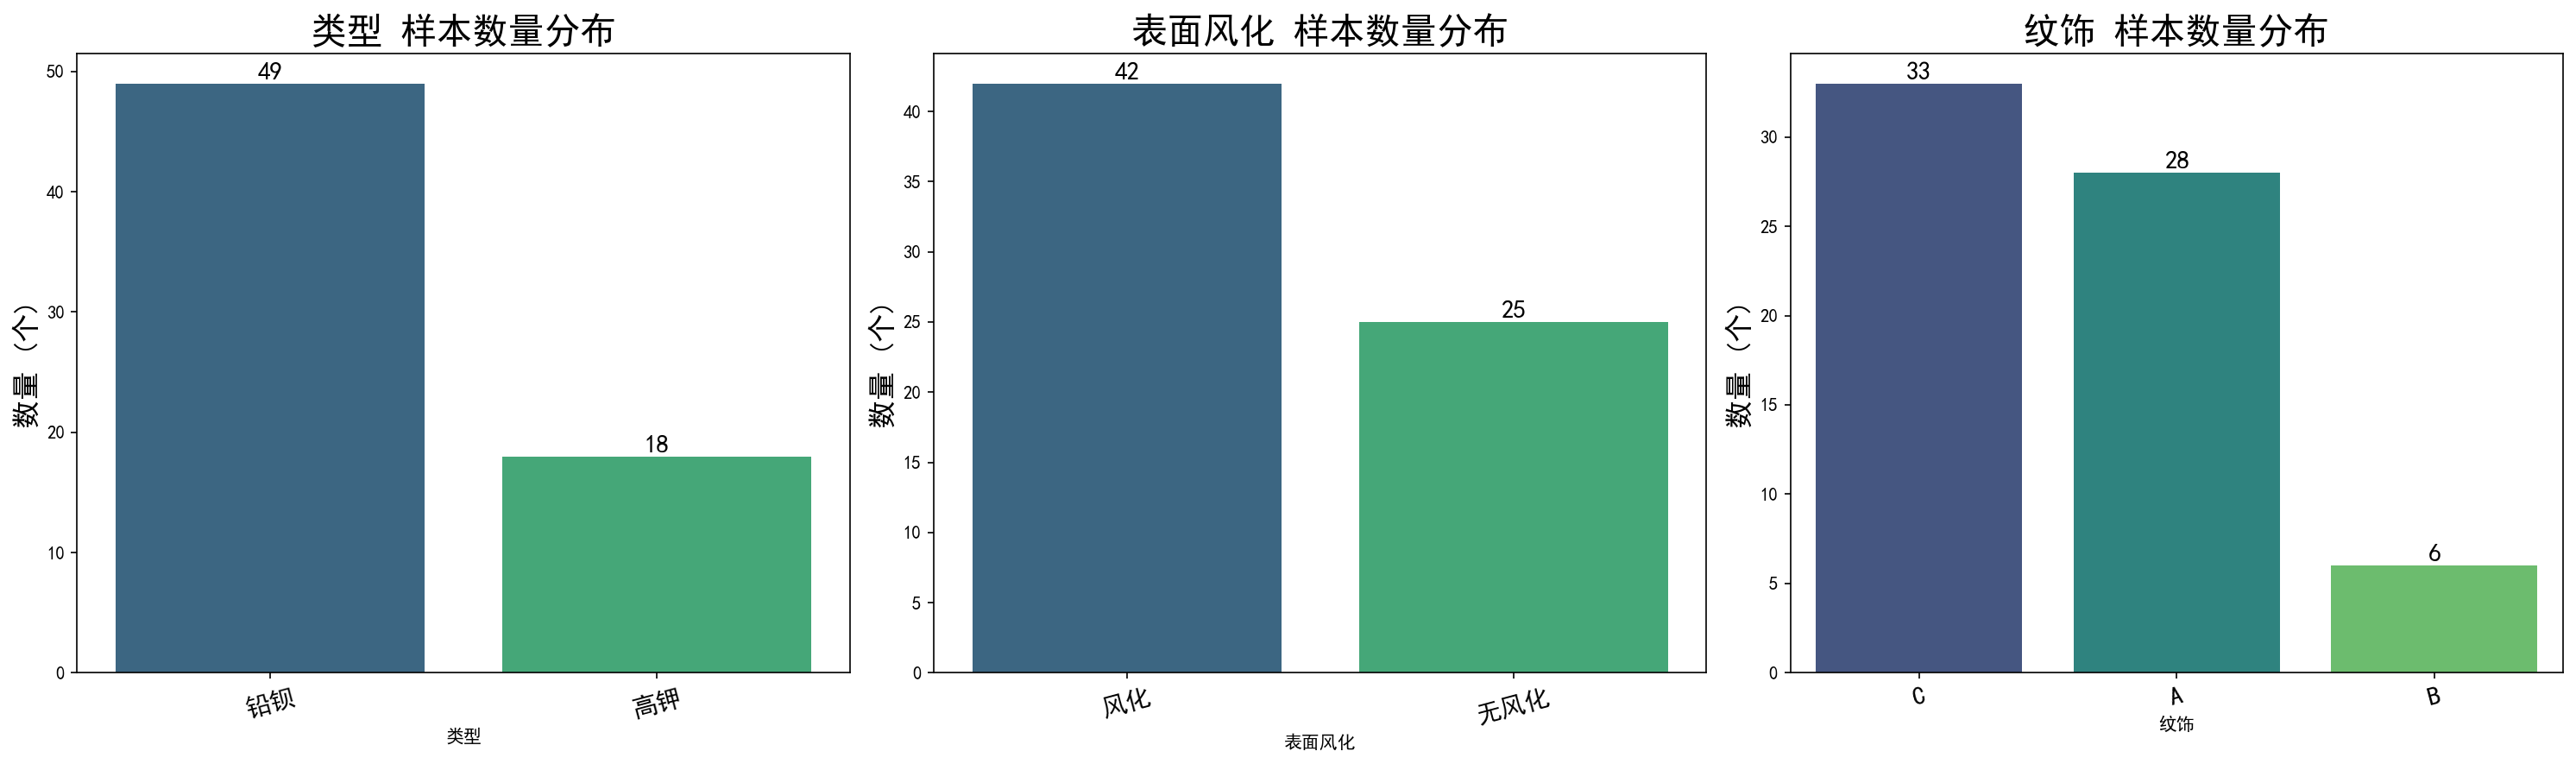

In [16]:
# --- (1.1) 分类特征样本分布图 ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 一行三图
plot_cols = ['类型', '表面风化', '纹饰']

for i, col in enumerate(plot_cols):
    counts = df_cleaned[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'{col} 样本数量分布', fontsize=20)
    axes[i].set_ylabel('数量 (个)', fontsize=16)
    axes[i].tick_params(axis='x', rotation=15, labelsize=14)
    for index, value in enumerate(counts):
        axes[i].text(index, value, str(value), ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.savefig("图1-分类特征样本数量分布.png")
plt.show()

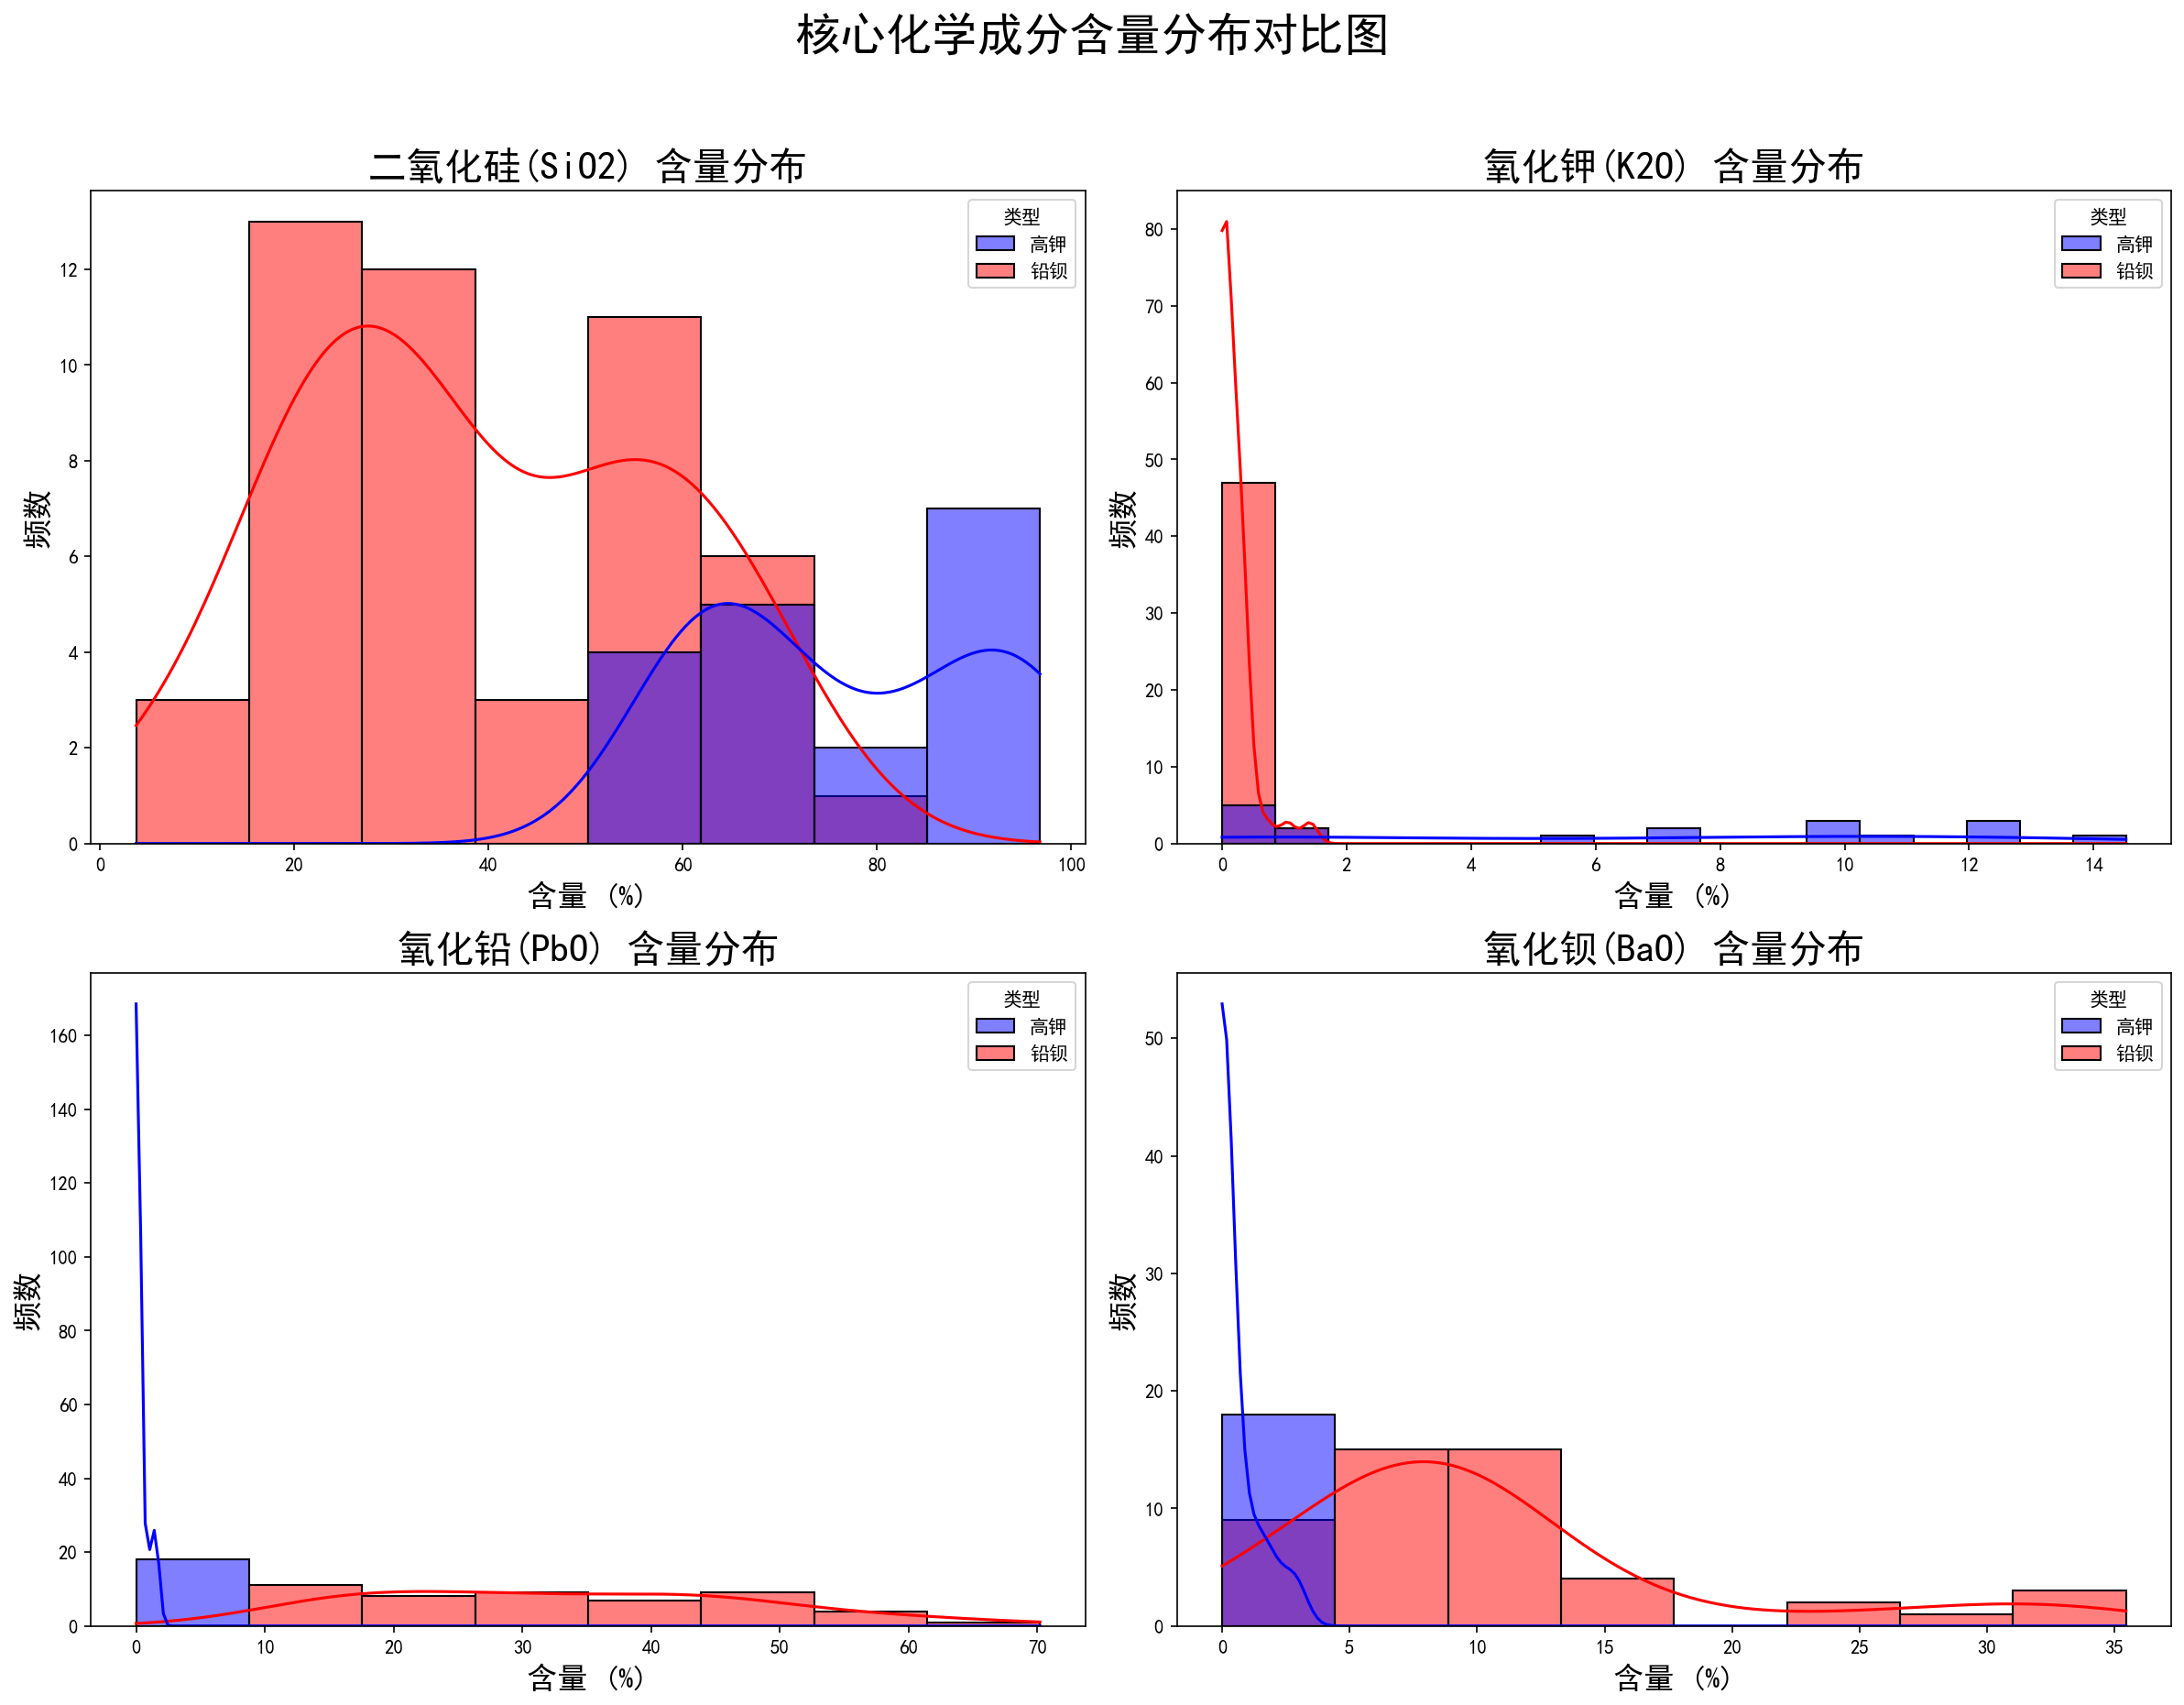

In [17]:
# --- (1.2) 核心化学成分含量分布图 ---
key_components_dist = ['二氧化硅(SiO2)', '氧化钾(K2O)', '氧化铅(PbO)', '氧化钡(BaO)']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, chemical in enumerate(key_components_dist):
    sns.histplot(df_cleaned, x=chemical, hue='类型', kde=True, ax=axes[i], 
                 palette={'高钾': 'blue', '铅钡': 'red', '未知': 'grey'})
    axes[i].set_title(f'{chemical} 含量分布', fontsize=20)
    axes[i].set_xlabel('含量 (%)', fontsize=16)
    axes[i].set_ylabel('频数', fontsize=16)
    # 手动设置图例，避免因数据分组不全导致的标签错误
    handles, labels = axes[i].get_legend_handles_labels()
    # 假设颜色顺序是 铅钡 -> 高钾
    if handles:
        axes[i].legend(handles, ['铅钡', '高钾'], title='玻璃类型')


fig.suptitle('核心化学成分含量分布对比图', fontsize=24, y=1.03)
plt.tight_layout()
plt.savefig("图2-核心化学成分含量分布.png")
plt.show()

--- 正在生成【斯皮尔曼】相关性对比热力图 ---


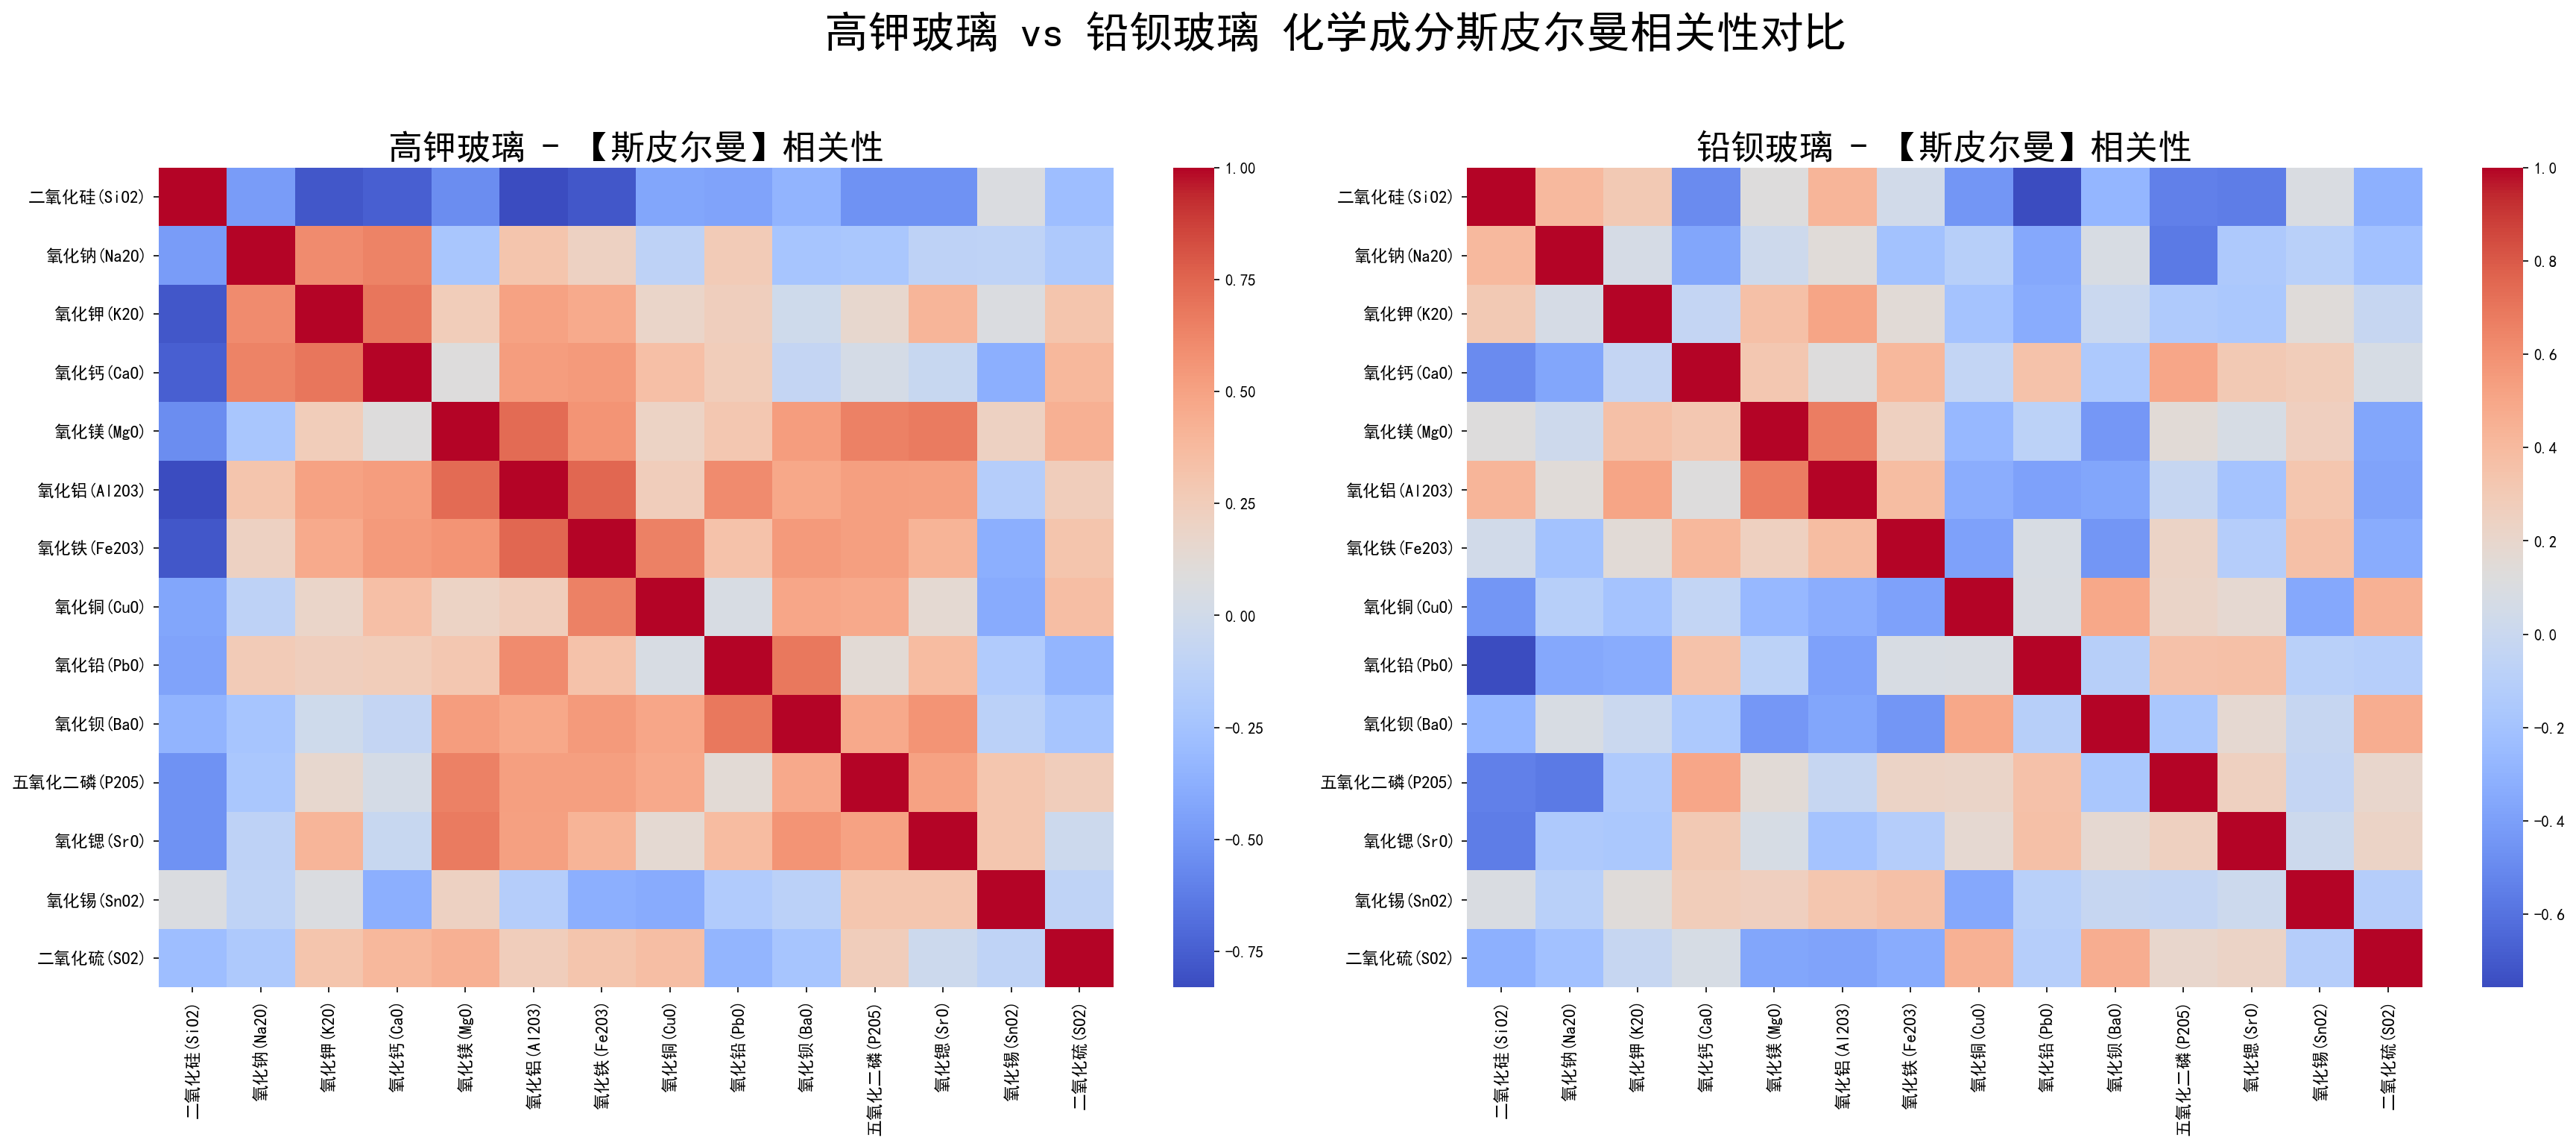

In [21]:
# --- 准备工作 ---
# 假设 df_cleaned 和 chemical_columns 已经存在
# 如果不存在，请先运行之前的预处理代码
df_K = df_cleaned[df_cleaned['类型'] == '高钾']
df_PbBa = df_cleaned[df_cleaned['类型'] == '铅钡']

# --- 核心绘图步骤 ---
print("--- 正在生成【斯皮尔曼】相关性对比热力图 ---")

# (1) 创建一个1行2列的子图，用于并列放置两张热力图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# (2) 绘制左侧：高钾玻璃的斯皮尔曼相关性热力图
# 【核心修改】在这里使用 method='spearman'
corr_K_spearman = df_K[chemical_columns].corr(method='spearman')
sns.heatmap(corr_K_spearman, ax=ax1, cmap='coolwarm', annot=False)
ax1.set_title('高钾玻璃 - 【斯皮尔曼】相关性', fontsize=22)
ax1.tick_params(axis='x', labelsize=11, rotation=90)
ax1.tick_params(axis='y', labelsize=11)


# (3) 绘制右侧：铅钡玻璃的斯皮尔曼相关性热力图
# 【核心修改】在这里同样使用 method='spearman'
corr_PbBa_spearman = df_PbBa[chemical_columns].corr(method='spearman')
sns.heatmap(corr_PbBa_spearman, ax=ax2, cmap='coolwarm', annot=False)
ax2.set_title('铅钡玻璃 - 【斯皮尔曼】相关性', fontsize=22)
ax2.tick_params(axis='x', labelsize=11, rotation=90)
ax2.tick_params(axis='y', labelsize=11)


# (4) 整体美化、保存并显示图表
fig.suptitle('高钾玻璃 vs 铅钡玻璃 化学成分斯皮尔曼相关性对比', fontsize=28, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("斯皮尔曼相关性对比热力图.png")
plt.show()

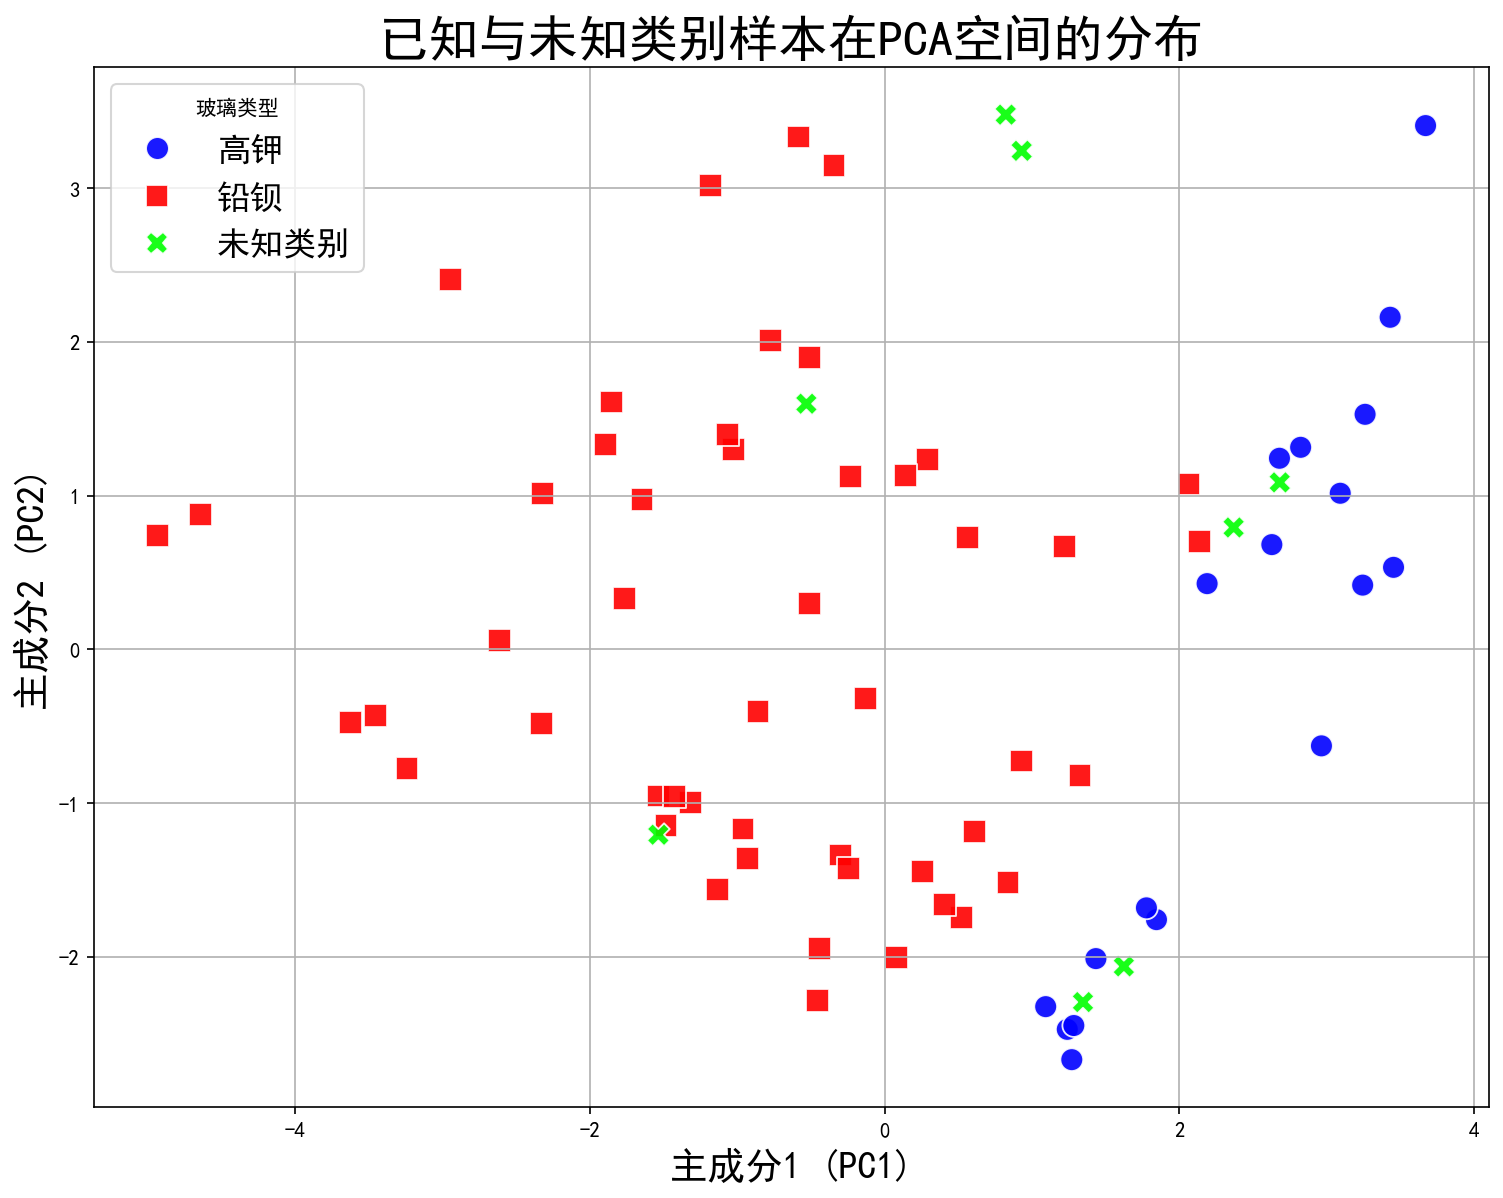

In [19]:
# --- (1.4) 包含未知类别的PCA降维可视化 ---
# (这部分代码依赖之前的计算，这里重新整理)
X_pca = df_cleaned[chemical_columns]
y_pca = df_cleaned['类型']
scaler = StandardScaler()
pca = PCA(n_components=2)
X_scaled = scaler.fit_transform(X_pca)
principal_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['主成分1 (PC1)', '主成分2 (PC2)'])
df_pca['类型'] = y_pca.values

X_unknown = df_unclassified_cleaned[chemical_columns]
X_unknown_scaled = scaler.transform(X_unknown)
unknown_principal_components = pca.transform(X_unknown_scaled)
df_unknown_pca = pd.DataFrame(data=unknown_principal_components, columns=['主成分1 (PC1)', '主成分2 (PC2)'])
df_unknown_pca['类型'] = '未知类别'

df_combined_pca = pd.concat([df_pca, df_unknown_pca], ignore_index=True)

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='主成分1 (PC1)', y='主成分2 (PC2)', hue='类型', style='类型',
    markers={'高钾': 'o', '铅钡': 's', '未知类别': 'X'},
    palette={'高钾': 'blue', '铅钡': 'red', '未知类别': 'lime'},
    data=df_combined_pca, s=120, alpha=0.9
)
plt.title('已知与未知类别样本在PCA空间的分布', fontsize=24)
plt.xlabel('主成分1 (PC1)', fontsize=18)
plt.ylabel('主成分2 (PC2)', fontsize=18)
plt.legend(title='玻璃类型', fontsize=16)
plt.grid(True)
plt.savefig("图4-问题三探索性分析PCA图.png")
plt.show()

C:\Users\86185\AppData\Local\Temp\ipykernel_27756\2029928678.py:57: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86185\AppData\Local\Temp\ipykernel_27756\2029928678.py:57: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86185\AppData\Local\Temp\ipykernel_27756\2029928678.py:57: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86185\AppData\Local\Temp\ipykernel_27756\2029928678.py:57: UserWarning: Glyph 28176 (\N{CJK UNIFIED IDEOGRAPH-6E10}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86185\AppData\Local\Temp\ipykernel_27756\2029928678.py:57: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86185\AppData\Local\Temp\ipykernel_27756\2029928678.py:57: UserWarning: Glyph 26609 (\

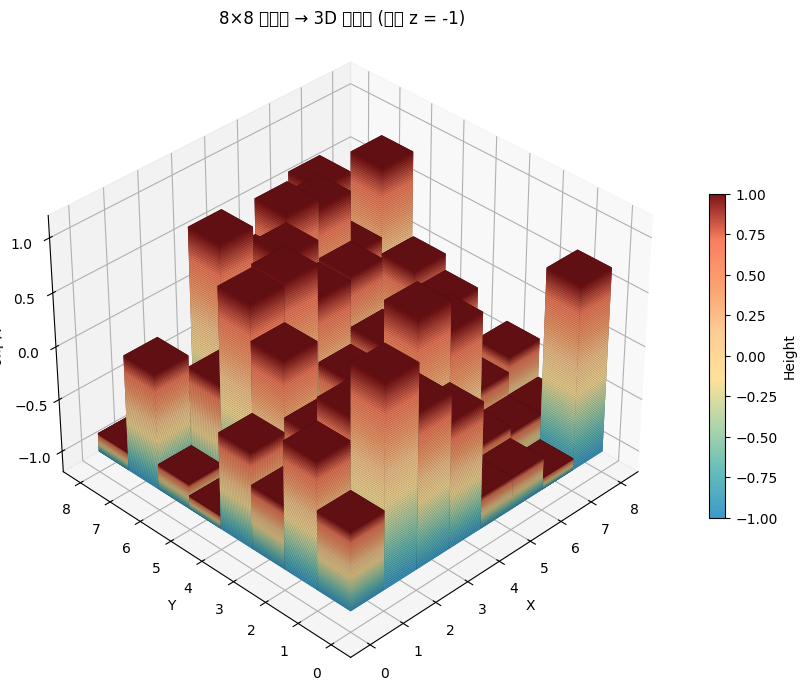

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------
# 1. 数据
np.random.seed(42)
Z = np.random.rand(8, 8) * 2          # 0~2 高度
base_z = -1                           # 基底统一 -1
n_rows, n_cols = Z.shape

# --------------------------------------------------
# 2. 颜色映射：低蓝 → 高红   （你的亮色系，已按深浅排序）
hex_colors = ['#3C9BC9', '#65BDBA', '#B0D6A9', '#FEE199',
              '#FDCD94', '#FAA26F', '#F97F5F', '#7D1317']
cmap = mcolors.LinearSegmentedColormap.from_list('custom', hex_colors, N=256)

# --------------------------------------------------
# 3. 画 3D 图
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# 逐根柱子画
for y in range(n_rows):
    for x in range(n_cols):
        h = Z[y, x]
        # 让柱子从 z = base_z 开始
        z = np.linspace(base_z, base_z + h, 100)          # 100 层做渐变
        # 径向距离 r：决定该层颜色
        r = (z - base_z) / (h if h else 1e-6)
        r = np.clip(r, 0, 1)
        color = cmap(r)

        # 画很多薄片，叠成一根柱子（实现真正渐变）
        dz = h / 100
        for k in range(len(z)-1):
            # 每片高度 dz，颜色取该层顶部颜色
            ax.bar3d(x, y, z[k], 1, 1, dz,
                     color=color[k+1], shade=True, edgecolor='none')

# --------------------------------------------------
# 4. 大俯瞰视角
ax.view_init(elev=35, azim=-135)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('8×8 热力图 → 3D 渐变柱 (基底 z = -1)')
ax.set_zlim(base_z - 0.2, base_z + 2.2)

# 颜色条
norm = mcolors.Normalize(vmin=base_z, vmax=base_z + 2)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, shrink=0.5, label='Height')

plt.tight_layout()
plt.show()